In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

# # use notebook path to find repo root, path to repo parent directory, and airflow dags repo
# # note that the two repos must by subdirs in some common parent for this to work
# nb_path = Path(os.path.abspath(""))
# emp_retention_repo_path = nb_path.parent
# all_repos_parent_path = emp_retention_repo_path.parent
# # append airflow-dags projs path and emp_retention repo path to python path
# sys.path.append(str(emp_retention_repo_path))


# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use(['dark_background'])

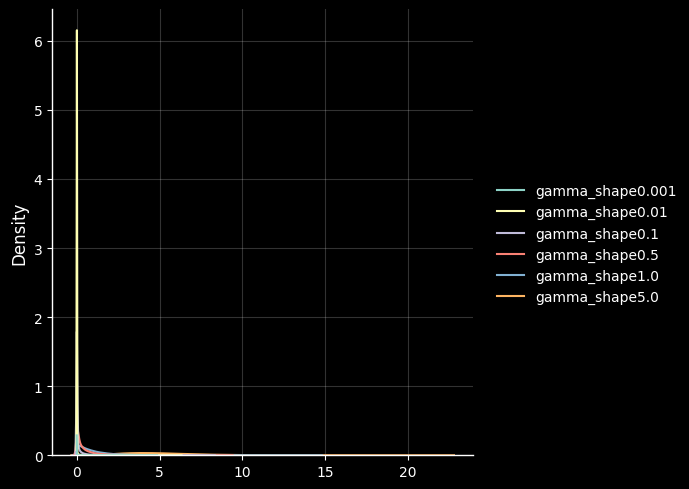

In [60]:
import numpy as np

rng = np.random.default_rng(42)

shapes = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0]   # decreasing skewness as k increases
scale = 1.0

samples = {
    k: rng.gamma(shape=k, scale=scale, size=200_000)
    for k in shapes
}
df_gamma = pd.DataFrame(samples)#
df_gamma.columns = [f'gamma_shape{shape}' for shape in shapes]
sns.displot(data = df_gamma, kind='kde'); plt.grid(alpha=0.2)

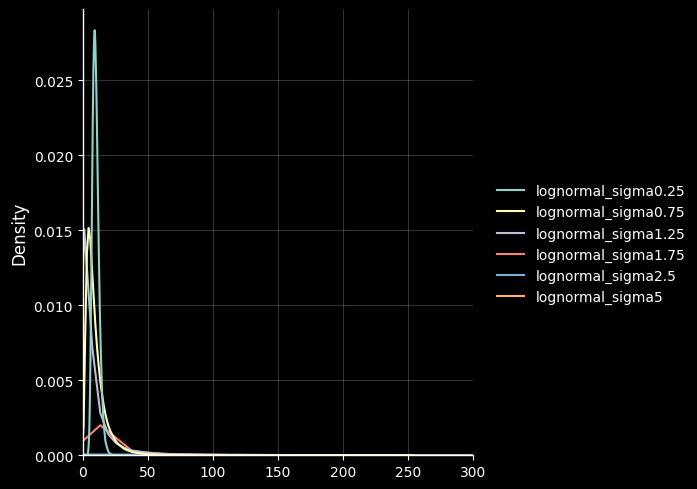

In [45]:
import numpy as np

rng = np.random.default_rng(42)

mu = 10.0
sigmas = [0.25, 0.75, 1.25, 1.75, 2.5, 5]  # controls skewness

samples_lognorm = {}

for sigma_log in sigmas:
    mu_log = np.log(mu) - 0.5 * sigma_log**2
    x = rng.lognormal(mean=mu_log, sigma=sigma_log, size=200_000)
    samples_lognorm[sigma_log] = x

df_lognormal = pd.DataFrame(samples_lognorm)#
df_lognormal.columns = [f'lognormal_sigma{sigma}' for sigma in sigmas]
    
sns.displot(data = df_lognormal, kind='kde')
plt.xlim(0,300); plt.grid(alpha=0.2)

In [33]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def clt_sampling_distribution(
    x: pd.Series | np.ndarray,
    n: int,
    reps: int = 50_000,
    seed: int = 0,
    ddof: int = 0,
    return_standardized: bool = True,
):
    """
    Build the sampling distribution of the sample mean (and optionally its CLT-standardized form)
    for a single column of data x treated as an empirical population (bootstrap-with-replacement).

    What it does
    ------------
    For r = 1..reps:
      - draw n samples with replacement from x
      - compute the sample mean M_r

    The CLT predicts (approximately, for large n):
      M ~ Normal( E[X], Var[X]/n )

    and the standardized mean:
      Z = (M - E[X]) / sqrt(Var[X]/n)  ~ Normal(0,1)

    Parameters
    ----------
    x : array-like
        One column of your df (e.g., df_lognormal["lognormal_sigma0.75"]).
        Interpreted as an empirical population to resample from.
    n : int
        Sample size per mean.
    reps : int
        Number of simulated sample means.
    seed : int
        RNG seed.
    ddof : int
        Degrees of freedom for variance in the "expected" calculation:
          ddof=0 uses population variance (matches CLT statement Var(X)/n).
          ddof=1 uses sample-variance-style estimate of Var(X).
    return_standardized : bool
        If True, also return standardized means Z and their summary.

    Returns
    -------
    result : dict
        Contains:
          - "means": array of simulated sample means (length reps)
          - "mean_emp", "var_emp", "std_emp": empirical moments of that sampling distribution
          - "mean_clt", "var_clt", "std_clt": CLT-predicted moments for sample mean
          - If return_standardized:
              - "z": standardized means
              - "z_mean_emp", "z_var_emp", "z_std_emp": empirical moments of z
              - "z_mean_clt", "z_var_clt", "z_std_clt": CLT target moments (0,1,1)
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x)
    x = x[np.isfinite(x)]

    if x.size == 0:
        raise ValueError("Input x has no finite values.")
    if n <= 0:
        raise ValueError("n must be a positive integer.")
    if reps <= 0:
        raise ValueError("reps must be a positive integer.")

    # "Population" moments (estimated from your column)
    mu_hat = x.mean()
    var_hat = x.var(ddof=ddof)

    # CLT-predicted sampling distribution for the mean
    mean_clt = mu_hat
    var_clt = var_hat / n
    std_clt = np.sqrt(var_clt)

    # Simulate sampling distribution of the mean via resampling from x
    # (treat x as empirical distribution)
    idx = rng.integers(0, x.size, size=(reps, n))
    sample_means = x[idx].mean(axis=1)

    mean_emp = sample_means.mean()
    var_emp = sample_means.var(ddof=0)
    std_emp = np.sqrt(var_emp)

    out = {
        "means": sample_means,
        "mean_emp": mean_emp,
        "var_emp": var_emp,
        "std_emp": std_emp,
        "mean_clt": mean_clt,
        "var_clt": var_clt,
        "std_clt": std_clt,
        "n": n,
        "reps": reps,
        "mu_hat": mu_hat,
        "var_hat": var_hat,
        "ddof": ddof,
    }

    if return_standardized:
        # Standardize using CLT scaling based on the same mu_hat/var_hat
        z = (sample_means - mean_clt) / (std_clt + 1e-15)

        out.update({
            "z": z,
            "z_mean_emp": z.mean(),
            "z_var_emp": z.var(ddof=0),
            "z_std_emp": z.std(ddof=0),
            "z_mean_clt": 0.0,
            "z_var_clt": 1.0,
            "z_std_clt": 1.0,
        })

    return out


def clt_summary_table(result: dict) -> pd.DataFrame:
    """
    Convenience: return a small, readable table comparing empirical vs CLT-expected
    moments for the sample-mean distribution (and standardized form if present).
    """
    rows = [
        {"quantity": "mean of sample means", "empirical": result["mean_emp"], "clt_expected": result["mean_clt"]},
        {"quantity": "var of sample means",  "empirical": result["var_emp"],  "clt_expected": result["var_clt"]},
        {"quantity": "std of sample means",  "empirical": result["std_emp"],  "clt_expected": result["std_clt"]},
    ]
    if "z" in result:
        rows += [
            {"quantity": "mean of standardized means (Z)", "empirical": result["z_mean_emp"], "clt_expected": result["z_mean_clt"]},
            {"quantity": "var of standardized means (Z)",  "empirical": result["z_var_emp"],  "clt_expected": result["z_var_clt"]},
            {"quantity": "std of standardized means (Z)",  "empirical": result["z_std_emp"],  "clt_expected": result["z_std_clt"]},
        ]
    return pd.DataFrame(rows)

In [36]:
import numpy as np
import pandas as pd

def clt_table_over_n(
    x: pd.Series | np.ndarray,
    n_min: int = 5,
    n_max: int = 500,
    num_n: int = 10,
    reps: int = 50_000,
    seed: int = 0,
    ddof: int = 0,
):
    """
    For a single empirical distribution x, simulate the sampling distribution
    of the mean for multiple n and return a tidy CLT comparison table.

    Parameters
    ----------
    x : array-like
        One column of your lognormal df.
    n_min, n_max : int
        Min and max sample sizes.
    num_n : int
        Number of n values between n_min and n_max (log-spaced).
    reps : int
        Number of sample means per n.
    seed : int
        RNG seed.
    ddof : int
        Variance convention for estimating Var(X) used in CLT formula.

    Returns
    -------
    DataFrame with one row per n, including:
      - empirical mean / var / std of sample means
      - CLT-predicted mean / var / std
      - empirical moments of standardized means
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x)
    x = x[np.isfinite(x)]

    if x.size == 0:
        raise ValueError("Input x has no finite values.")

    # "Population" moments (estimated from data)
    mu_hat = x.mean()
    var_hat = x.var(ddof=ddof)

    # n values (log-spaced, integer)
    ns = np.unique(
        np.round(
            np.logspace(np.log10(n_min), np.log10(n_max), num_n)
        ).astype(int)
    )

    rows = []

    for n in ns:
        # sample means
        idx = rng.integers(0, x.size, size=(reps, n))
        sample_means = x[idx].mean(axis=1)

        # empirical sampling distribution moments
        mean_emp = sample_means.mean()
        var_emp = sample_means.var(ddof=0)
        std_emp = np.sqrt(var_emp)

        # CLT prediction
        mean_clt = mu_hat
        var_clt = var_hat / n
        std_clt = np.sqrt(var_clt)

        # standardized means
        z = (sample_means - mean_clt) / (std_clt + 1e-15)

        rows.append({
            "n": n,
            "mean_emp": mean_emp,
            "mean_clt": mean_clt,
            "var_emp": var_emp,
            "var_clt": var_clt,
            "std_emp": std_emp,
            "std_clt": std_clt,
            "z_mean_emp": z.mean(),
            "z_var_emp": z.var(ddof=0),
            "z_std_emp": z.std(ddof=0),
        })

    return pd.DataFrame(rows)


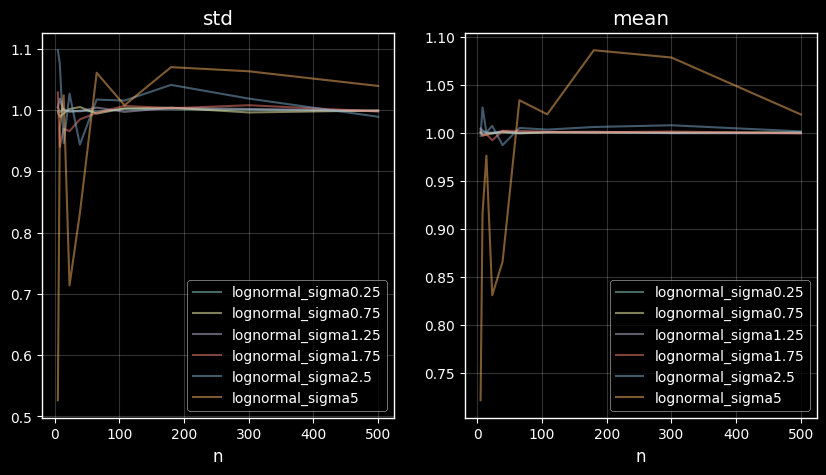

In [59]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

for sigma in sigmas:

    clt_df = clt_table_over_n(
        x = df_lognormal[f"lognormal_sigma{sigma}"],
        n_min=5,
        n_max=500,
        num_n=10,
        reps=50_000,
        seed=42,
    )
    clt_df['clt_emp_ratio_mean'] = clt_df.mean_emp / clt_df.mean_clt
    clt_df['clt_emp_ratio_std']  = clt_df.std_emp  / clt_df.std_clt
    for ax, metric in zip(axes, ['std','mean']):
        clt_df.set_index('n')[[f'clt_emp_ratio_{metric}']].plot(ax=ax,label=f'lognormal_sigma{sigma}', alpha=0.5)
        ax.set_title(metric)
for ax in axes:
    ax.grid(alpha=0.2);
    ax.legend(df_lognormal.columns)

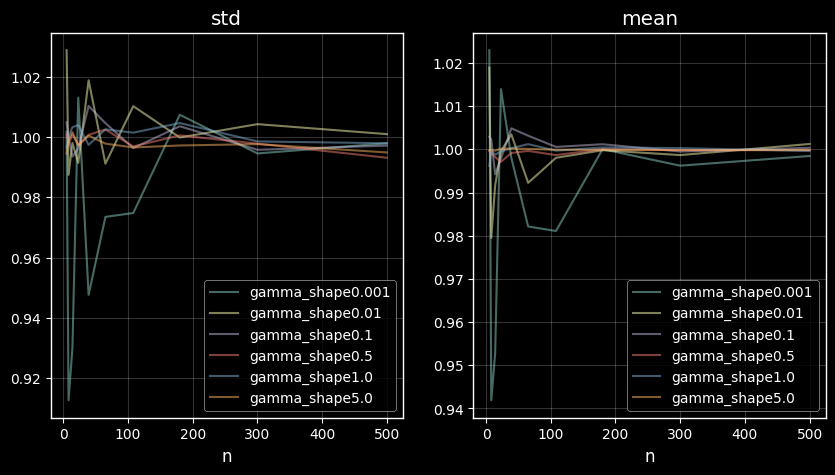

In [61]:
fig, axes = plt.subplots(1,2,figsize=(10,5))

for sigma in shapes:

    clt_df = clt_table_over_n(
        x = df_gamma[f"gamma_shape{sigma}"],
        n_min=5,
        n_max=500,
        num_n=10,
        reps=50_000,
        seed=42,
    )
    clt_df['clt_emp_ratio_mean'] = clt_df.mean_emp / clt_df.mean_clt
    clt_df['clt_emp_ratio_std']  = clt_df.std_emp  / clt_df.std_clt
    for ax, metric in zip(axes, ['std','mean']):
        clt_df.set_index('n')[[f'clt_emp_ratio_{metric}']].plot(ax=ax,label=f'gamma_shape{sigma}', alpha=0.5)
        ax.set_title(metric)
for ax in axes:
    ax.grid(alpha=0.2);
    ax.legend(df_gamma.columns)